In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df.head()

,Period,Sessions,Cluster
0,2011-07-29 20:00:00,1,HAMILTON
1,2011-07-29 20:30:00,1,HAMILTON
2,2011-07-29 21:00:00,1,HAMILTON
3,2011-07-29 21:30:00,1,HAMILTON
4,2011-07-29 22:00:00,1,HAMILTON


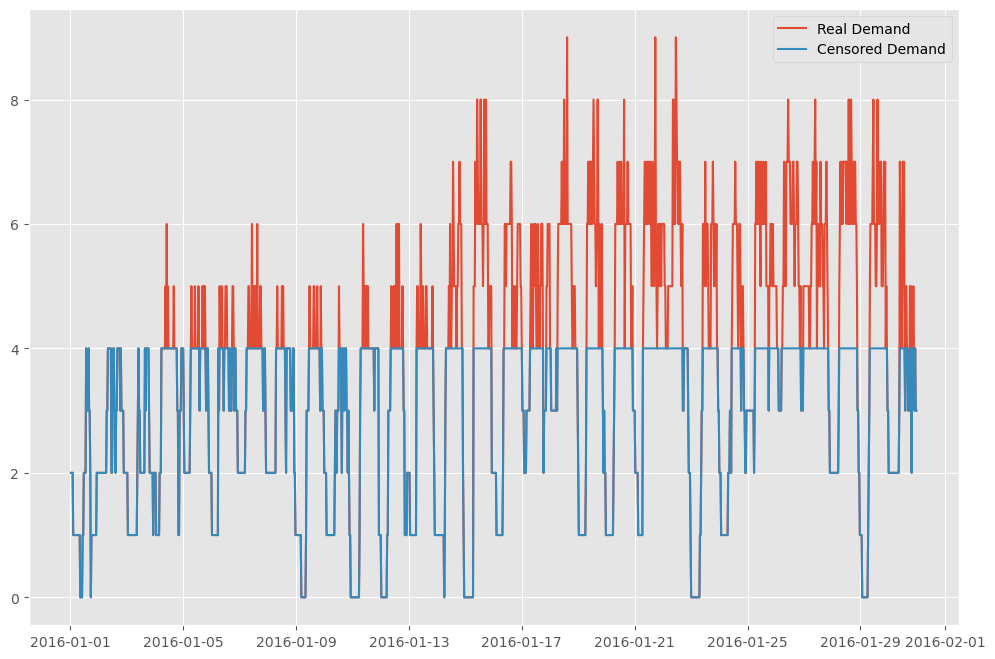

In [20]:

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))

df_sample = df[(df.Cluster == 'WEBSTER') & ((df.Period > '2016-01-01') & (df.Period < '2016-01-31'))].copy()
df_sample['Censored'] = df_sample['Sessions'].values

df_sample.loc[df_sample.Sessions > 4, 'Censored'] = 4

plt.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand')
plt.plot(df_sample.Period, df_sample.Censored.values, label='Censored Demand')
plt.legend()
plt.show()

In [21]:
import torch.nn as nn
import torch
import numpy as np

In [22]:
class AR_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(AR_Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.relu = nn.ReLU()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class AR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AR, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim) 

    def forward(self, x):
        out = self.fc1(x)
        return out

In [23]:
input_dim = 48*7
output_dim = 48

X_train = df_sample.reset_index(drop=True).iloc[:input_dim]
y_train = df_sample.reset_index(drop=True).iloc[input_dim:input_dim+output_dim]

model = AR(input_dim, output_dim)

In [24]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    return loss.data.item()


Epoch: 0 Loss: 0.0005254744901321828
Epoch: 1 Loss: 89.8787841796875
Epoch: 2 Loss: 5.876916885375977
Epoch: 3 Loss: 19.046201705932617
Epoch: 4 Loss: 51.71608352661133
Epoch: 5 Loss: 39.490753173828125
Epoch: 6 Loss: 11.609333992004395
Epoch: 7 Loss: 0.02266656421124935
Epoch: 8 Loss: 10.481922149658203
Epoch: 9 Loss: 24.175615310668945
Epoch: 10 Loss: 24.140127182006836
Epoch: 11 Loss: 12.62234878540039
Epoch: 12 Loss: 1.9544683694839478
Epoch: 13 Loss: 0.8371636271476746
Epoch: 14 Loss: 7.584619045257568
Epoch: 15 Loss: 13.387177467346191
Epoch: 16 Loss: 12.215119361877441
Epoch: 17 Loss: 5.938510417938232
Epoch: 18 Loss: 0.7206171154975891
Epoch: 19 Loss: 0.6674246788024902
Epoch: 20 Loss: 4.462939739227295
Epoch: 21 Loss: 7.397525310516357
Epoch: 22 Loss: 6.454395771026611
Epoch: 23 Loss: 2.8874690532684326
Epoch: 24 Loss: 0.22899110615253448
Epoch: 25 Loss: 0.5846126675605774
Epoch: 26 Loss: 2.8370354175567627
Epoch: 27 Loss: 4.205028057098389
Epoch: 28 Loss: 3.2705373764038086
E

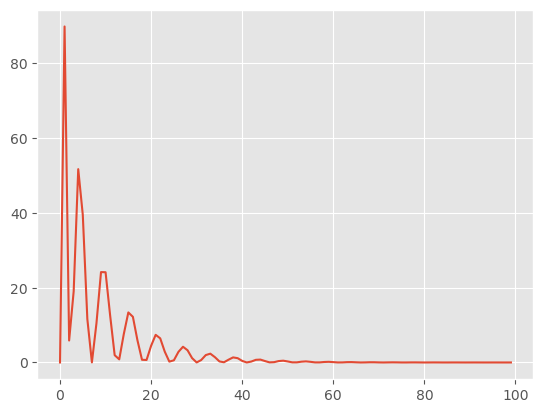

In [32]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
losses = []
for epoch in range(epochs):
    x = torch.tensor(X_train.Sessions.values, dtype=torch.float32).view(1, -1)
    y = torch.tensor(y_train.Sessions.values, dtype=torch.float32).view(1, -1)
    loss = train_batch(model, x, y, optimizer, loss_fn)
    losses.append(loss)
    print(f'Epoch: {epoch} Loss: {loss}')
plt.plot(losses)

In [38]:
# make prediction
y_predict = model.forward(x)
y_predict = y_predict.detach().numpy().reshape(-1).round()

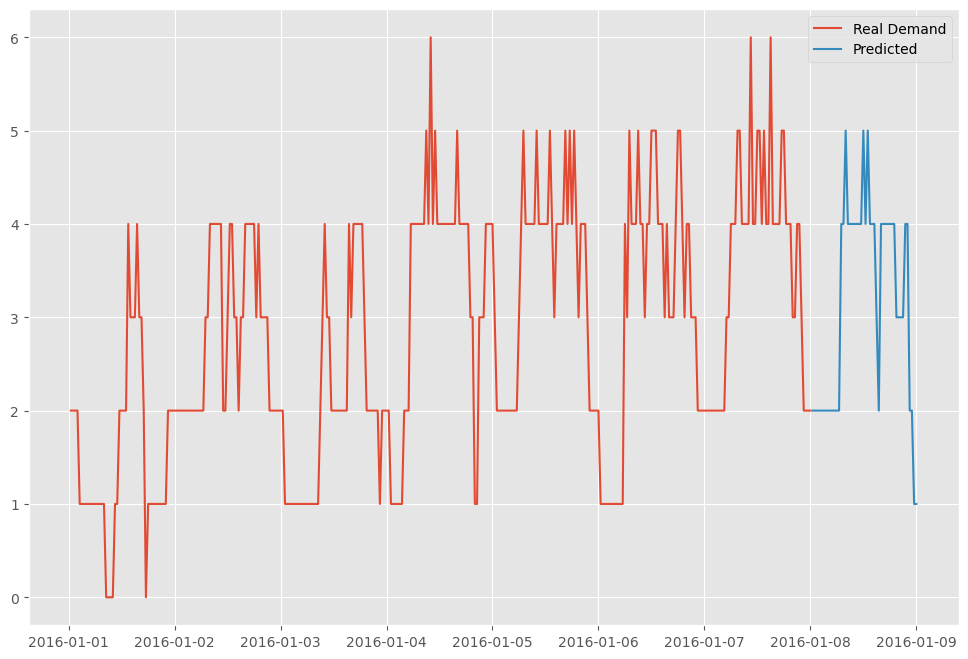

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(X_train.Period, X_train.Sessions.values, label='Real Demand')
plt.plot(y_train.Period, y_predict, label='Predicted')
plt.legend()

In [35]:
np.exp(y_predict)

/var/folders/yl/b9_wj9rx061bz1tpzkk98g440000gn/T/ipykernel_36227/120618228.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(y_predict)


array([4.0975705e+02, 8.7917297e+02, 8.7654089e+02, 4.0982837e+02,
       8.6672137e+02, 8.7579553e+02, 4.1076297e+02, 4.1189880e+02,
       8.7389832e+02, 8.7509760e+02, 8.8260303e+02, 4.1516302e+02,
       8.6590222e+02, 3.4094659e+24, 1.2199878e+22,           inf,
       3.4663954e+24, 3.4535925e+24, 3.4137735e+24, 1.1963043e+22,
       3.3807143e+24, 1.2333520e+22, 1.2299972e+22,           inf,
       3.1989649e+24,           inf, 3.3779297e+24, 1.2113899e+22,
       3.4106756e+24, 7.1902960e+07, 8.8195807e+02, 1.2326794e+22,
       3.3513739e+24, 1.2829774e+22, 1.2294953e+22, 1.2199133e+22,
       1.2692400e+22, 1.2488665e+22, 5.5201274e+08, 5.6043520e+08,
       5.5382566e+08, 7.1165368e+07, 1.2808501e+22, 3.3849726e+24,
       8.7472125e+02, 8.7877191e+02, 6.4429197e+00, 4.8657403e+00],
      dtype=float32)

In [29]:
torch.randn(5, 2)

tensor([[-0.9604, -0.5994],
        [-2.9680, -1.9345],
        [ 0.5404,  0.3563],
        [ 0.4195, -0.6082],
        [-0.0750, -0.1398]])

In [30]:
# Poisson loss pytorch


In [31]:
poisson_likelihood(5,10)

NameError: name 'poisson_likelihood' is not defined